In [3]:
import pyproj
import geopandas as gpd
from descartes import PolygonPatch
from shapely.geometry import shape
from shapely.geometry import Point

import glob
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt 
from matplotlib.collections import PatchCollection

import warnings
warnings.filterwarnings('ignore')

In [4]:
github_data = pd.concat([pd.read_csv(filename) for filename in glob.glob('../data/raw/github_data/*')])

shp_filename_de = '../data/raw/VG250_1Jan2011_WGS84/'
shp_filename_gb = '/Users/kstathou/Downloads/Travel_to_Work_Areas_December_2011_Full_Clipped_Boundaries_in_United_Kingdom/Travel_to_Work_Areas_December_2011_Full_Clipped_Boundaries_in_United_Kingdom.shp'

shapes_de = gpd.GeoDataFrame.from_file(shp_filename_de)
print(shapes_de.crs)

shapes_gb = gpd.GeoDataFrame.from_file(shp_filename_gb)
shapes_gb.crs = {"init": "epsg:27700"}
print(shapes_gb.crs)

{'init': 'epsg:4326'}
{'init': 'epsg:27700'}


In [5]:
# Users without a city default to the centre of a country
github_data = github_data[github_data.user_city.isnull()==False]
github_data.rename(index=str, inplace=True, columns={'user_latitude':'lat', 'user_longitude':'lng'})

In [6]:
# Geo transformations
def geo_transform(wgs84, grid):
    return lambda lng, lat : Point(*pyproj.transform(wgs84, grid, lng, lat))

def country_subset(df, country_code):
    df = df[df.user_country_code==country_code]
    df.reset_index(inplace=True, drop=True)
    return df

def geometry(df, shapes, code):
    df.crs = {"init": "epsg:{}".format(code)}
    df['geometry'] = [EnPoint(df.loc[i, 'lng'], df.loc[i, 'lat']) for i in range(df.shape[0])]
    # Perform the spatial join
    df = gpd.tools.sjoin(shapes, df, how="right")
    return df

In [7]:
EnPoint = geo_transform(pyproj.Proj(init = 'epsg:4326'), pyproj.Proj(init = 'epsg:4326'))
df_germany = geometry(country_subset(github_data, 'de'), shapes_de, '4326')

In [8]:
df_germany.shape

(554913, 33)

In [9]:
EnPoint = geo_transform(pyproj.Proj(init = 'epsg:4326'), pyproj.Proj(init = 'epsg:27700'))
df_gb = geometry(country_subset(github_data, 'gb'), shapes_gb, '27700')

In [10]:
df_gb.shape

(1036810, 24)

### Visualisations 

In [13]:
gb_percent = df_gb.groupby(['ttwa11nm']).count()['user_id'].sort_values(ascending=False) / df_gb.shape[0] * 100
de_percent = df_germany.groupby(['GEN']).count()['user_id'].sort_values(ascending=False) / df_germany.shape[0] * 100

In [14]:
def plotmap(shapes, data, object_col, location_col, ax):
    patches = []
    color = []
    for id_ in set(shapes[object_col]):
        patches.append(PolygonPatch(shapes.loc[id_-1, 'geometry'], alpha=0.5, zorder=4))
        try:
            color.append(data.loc[shapes[shapes[object_col]==id_][location_col]][0])
        except KeyError as e:
            color.append(0)

    scaled_color = np.log(color)
    scaled_color[scaled_color == -np.inf] = 0
    p = PatchCollection(patches, cmap=plt.cm.viridis, match_original=True)
    p.set_array(scaled_color)
    ax.add_collection(p)
    # ax.set_title('German users', fontsize=12)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.axis('off')
    # ax2.set_axis_off()
    ax.axis('scaled')

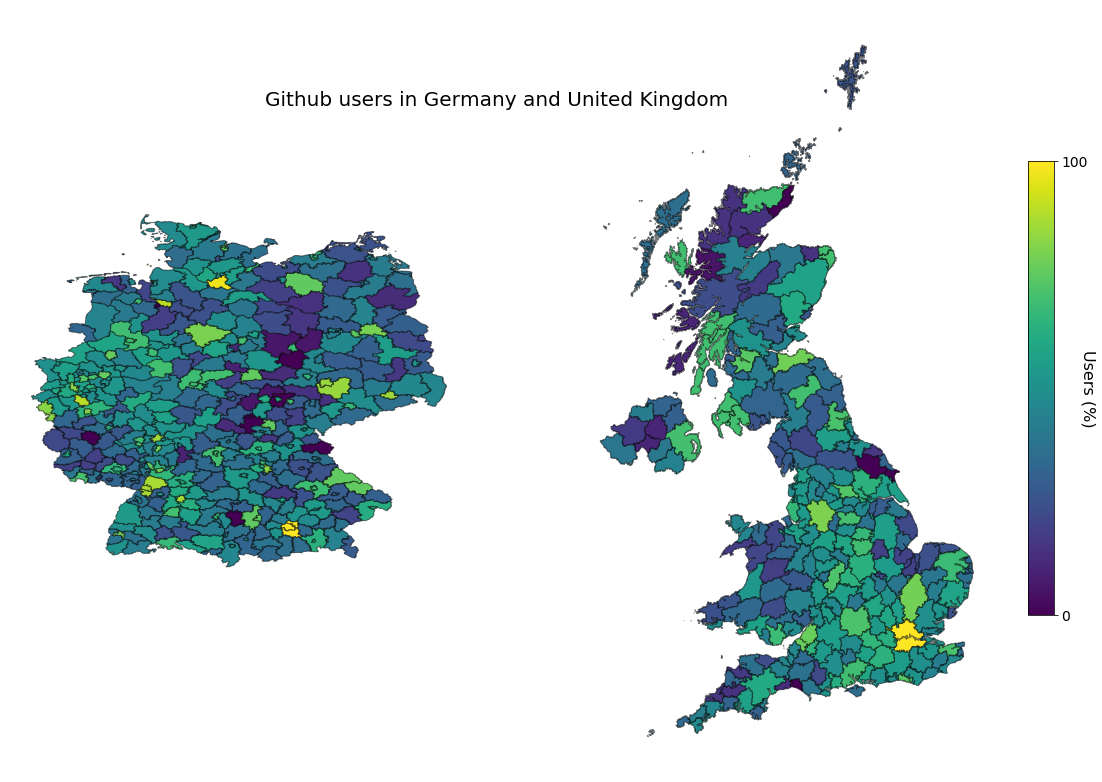

CPU times: user 27 s, sys: 514 ms, total: 27.5 s
Wall time: 28.1 s


In [15]:
%%time

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,14)) 

# ax1
plotmap(shapes_de, de_percent, 'OBJECTID', 'GEN', ax1)

# ax2
plotmap(shapes_gb, gb_percent, 'objectid', 'ttwa11nm', ax2)

plt.suptitle('Github users in Germany and United Kingdom', fontsize=20, y=0.8)

# Sidebar
cax = fig.add_axes([0.91, 0.28, 0.02, 0.45])
cb = mpl.colorbar.ColorbarBase(cax, cmap=plt.cm.viridis, spacing='proportional', ticks=[-1, 0, 1])
cb.ax.set_yticklabels(['0', '100'], fontsize=14) 
cb.set_label("Users (%)", labelpad=8, rotation=270, fontsize=16)

plt.show()